In [1]:
import sys
sys.path.append('../code/') 
import mocap_functions
from functools import partial
import numpy as np
import pandas as pd
import neo
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import signal
from scipy.interpolate import interp1d
import spike_train_functions
import elephant
import quantities as pq
# import h5py
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
import torch.nn.functional as F
from joblib import Parallel, delayed
import multiprocessing
import Neural_Decoding
import pickle
import seaborn as sns
from hnn_core.utils import smooth_waveform
#sns.set()
#sns.set_style("white")

num_cores = multiprocessing.cpu_count()
scaler = StandardScaler()

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
#device = torch.device("cuda:0")
device = torch.device('cpu')

torch.backends.cudnn.benchmark = True

In [2]:
kinematic_df, neural_df, metadata = mocap_functions.load_mocap_df('../data/SPK20220308/task_data/')


num_trials = metadata['num_trials']

#Generate cv_dict for regular train/test/validate split (no rolling window)
cv_split = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)
val_split = ShuffleSplit(n_splits=1, test_size=.25, random_state=0)
cv_dict = {}
for fold, (train_val_idx, test_idx) in enumerate(cv_split.split(np.arange(num_trials))):
    for t_idx, v_idx in val_split.split(train_val_idx): #No looping, just used to split train/validation sets
        cv_dict[fold] = {'train_idx':train_val_idx[t_idx], 
                         'test_idx':test_idx, 
                         'validation_idx':train_val_idx[v_idx]} 

In [3]:
carpal_df = kinematic_df[kinematic_df['name'].str.contains(pat='carpal')]
carpal_df['posData'] = carpal_df['posData'].map(partial(smooth_waveform, window_len=200, sfreq=100))

smooth_kinematic_df = kinematic_df.copy()
smooth_kinematic_df['posData'] = kinematic_df['posData'].map(partial(smooth_waveform, window_len=200, sfreq=100))

/tmp/ipykernel_45772/2674921949.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  carpal_df['posData'] = carpal_df['posData'].map(partial(smooth_waveform, window_len=200, sfreq=100))


In [4]:
plot_df

NameError: name 'plot_df' is not defined

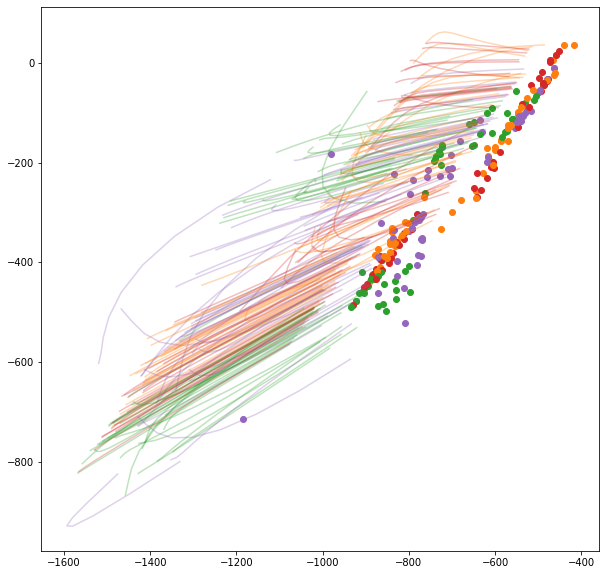

In [11]:
start=-10
stop=-1

plt.figure(figsize=(10,10))
for trial in range(216):

    plot_df = carpal_df[carpal_df['trial'] == trial]
    layout = plot_df['position'].values[0]
    #plt.subplot(2,2,layout)
    x_data = plot_df[plot_df['name'] == 'carpal_x']['posData'].values[0]
    y_data = plot_df[plot_df['name'] == 'carpal_y']['posData'].values[0]

    plt.plot(x_data[start:stop], y_data[start:stop], color=f'C{layout}', alpha=0.3)
    plt.scatter(x_data[stop], y_data[stop], color=f'C{layout}')
    #plt.xlim(-2000, 100)
    #plt.ylim(-2000, 2000)

Text(0.5, 0, 'z')

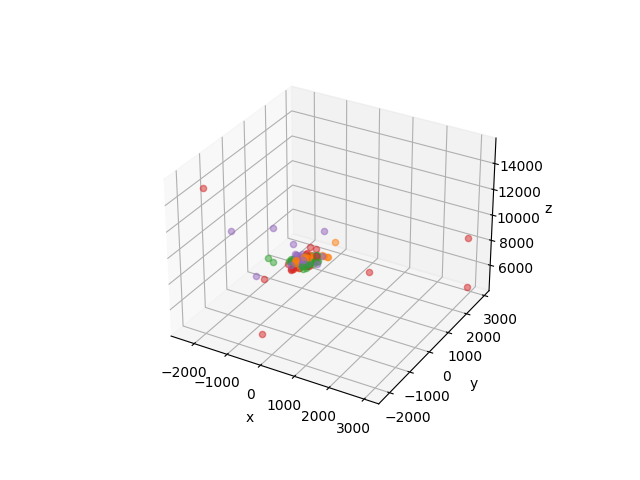

In [51]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
start=-200
stop=299
prefix = 'thumbProx'
for trial in range(216):

    plot_df = kinematic_df[kinematic_df['trial'] == trial]
    layout = plot_df['position'].values[0]
    #plt.subplot(2,2,layout)
    x_data = plot_df[plot_df['name'] == f'{prefix}_x']['posData'].values[0]
    y_data = plot_df[plot_df['name'] == f'{prefix}_y']['posData'].values[0]
    z_data = plot_df[plot_df['name'] == f'{prefix}_z']['posData'].values[0]

    #plt.plot(x_data[start:stop], y_data[start:stop], z_data[start:stop], color=f'C{layout}', alpha=0.3)
    ax.scatter(x_data[stop], y_data[stop], z_data[stop], color=f'C{layout}', alpha=0.5)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

#ax.set_xlim([-1100, -100])
#ax.set_ylim([-600, 400])
#ax.set_zlim([4600, 5600])

In [40]:
kinematic_df['name'].unique()[50:100]

array(['pinkyMid_z', 'pinkyDistal_x', 'pinkyDistal_y', 'pinkyDistal_z',
       'pinkyTip_x', 'pinkyTip_y', 'pinkyTip_z', 'carpal_x', 'carpal_y',
       'carpal_z', 'radiusProx_x', 'radiusProx_y', 'radiusProx_z',
       'radiusDistal_x', 'radiusDistal_y', 'radiusDistal_z',
       'ulnarProx_x', 'ulnarProx_y', 'ulnarProx_z', 'ulnarDistal_x',
       'ulnarDistal_y', 'ulnarDistal_z', 'righteye_insideeye_x',
       'righteye_insideeye_y', 'righteye_outsideeye_x',
       'righteye_outsideeye_y', 'righteye_pupilcenter_x',
       'righteye_pupilcenter_y', 'righteye_pupiltop_x',
       'righteye_pupiltop_y', 'righteye_pupilinside_x',
       'righteye_pupilinside_y', 'righteye_pupilbottom_x',
       'righteye_pupilbottom_y', 'righteye_pupiloutside_x',
       'righteye_pupiloutside_y', 'lefteye_insideeye_x',
       'lefteye_insideeye_y', 'lefteye_outsideeye_x',
       'lefteye_outsideeye_y', 'lefteye_pupilcenter_x',
       'lefteye_pupilcenter_y', 'lefteye_pupiltop_x',
       'lefteye_pupiltop_y'

In [3]:
# Filter dataframes add or remove layout info
nolayout_kinematic_mask = ~(kinematic_df['name'].str.contains(pat='layout'))
noposition_kinematic_mask = ~(kinematic_df['name'].str.contains(pat='position'))

eye_kinematic_mask = kinematic_df['name'].str.contains(pat='eye')
corneal_kinematic_mask = kinematic_df['name'].str.contains(pat='corneal')

temp_eye_df = kinematic_df[np.logical_or(eye_kinematic_mask, corneal_kinematic_mask)]
kinematic_df = kinematic_df[np.logical_and.reduce([nolayout_kinematic_mask, noposition_kinematic_mask, ~eye_kinematic_mask, ~corneal_kinematic_mask])]

nolayout_neural_mask = ~(neural_df['unit'].str.contains(pat='layout'))
noposition_neural_mask = ~(neural_df['unit'].str.contains(pat='position'))
notask_neural_df = neural_df[np.logical_and(nolayout_neural_mask, noposition_neural_mask)]



In [4]:
eye_data = [[data] for data in temp_eye_df['posData'].tolist()]
eye_dict = {'rates': eye_data, 'unit': temp_eye_df['name'].tolist(), 'trial': temp_eye_df['trial'].tolist(),
            'layout': temp_eye_df['layout'].tolist(), 'count': np.repeat(0.0, len(temp_eye_df))}

eye_df = pd.DataFrame(eye_dict).reset_index()

task_neural_noeyes_df = neural_df.copy()
notask_neural_noeyes_df = notask_neural_df.copy()
task_neural_eyes_df_ = pd.concat([eye_df, neural_df])
notask_neural_eyes_df = pd.concat([eye_df, notask_neural_df])
            

In [5]:
#GRU architecture for decoding kinematics
class model_gru(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, dropout, device, bidirectional=False,
                 cat_features=None):
        super(model_gru, self).__init__()

        #multiplier based on bidirectional parameter
        if bidirectional:
            num_directions = 2
        else:
            num_directions = 1

        # Defining some parameters
        self.hidden_dim = hidden_dim       
        self.n_layers = n_layers * num_directions
        self.device = device
        self.dropout = dropout
        self.bidirectional = bidirectional
        self.cat_features = cat_features

        #Defining the layers
        self.gru = nn.GRU(input_size, self.hidden_dim, n_layers, batch_first=True, dropout=dropout, bidirectional=bidirectional)   

        # Fully connected layer
        if cat_features is not None:
            self.fc = nn.Linear((self.hidden_dim + np.sum(self.cat_features))*num_directions, output_size)
        else:
            self.fc = nn.Linear(self.hidden_dim*num_directions, output_size)
    
    def forward(self, x):
        batch_size = x.size(0)
        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)
        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.gru(x, hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous()
        if self.cat_features is not None:
            out = torch.cat([out, x[:, :, self.cat_features]], 2)
        #print(out.size())
        out = self.fc(out)
        return out
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        weight = next(self.parameters()).data.to(self.device)

        #GRU initialization
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device)

        return hidden

### Use function to create train/test sets with each data frame

In [6]:
def run_wiener(pred_df, neural_df, neural_offset, task_info=True):
  if task_info:
    exclude_processing = np.zeros(len(neural_df['unit'].unique()))
    exclude_processing[-8:] = np.ones(8)
    exclude_processing = exclude_processing.astype(bool)
  else:
    exclude_processing = None
    
  data_arrays, generators = mocap_functions.make_generators(
    pred_df, neural_df, neural_offset, cv_dict, metadata, exclude_neural=exclude_processing, window_size=10)

  # Unpack tuple into variables
  training_set, validation_set, testing_set = data_arrays
  training_generator, training_eval_generator, validation_generator, testing_generator = generators

  X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
  y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

  X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
  y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

  #Fit and run wiener filter
  model_wr = Neural_Decoding.decoders.WienerFilterDecoder() 
  model_wr.fit(X_train_data,y_train_data)

  wr_train_pred = model_wr.predict(X_train_data)
  wr_test_pred = model_wr.predict(X_test_data)

  #Compute decoding
  wr_train_corr = mocap_functions.matrix_corr(wr_train_pred,y_train_data)
  wr_test_corr = mocap_functions.matrix_corr(wr_test_pred,y_test_data)

  return wr_train_pred, wr_test_pred, wr_train_corr, wr_test_corr

def run_rnn(pred_df, neural_df, neural_offset, task_info=True):
  if task_info:
    exclude_processing = np.zeros(len(neural_df['unit'].unique()))
    exclude_processing[-8:] = np.ones(8)
    exclude_processing = exclude_processing.astype(bool)
  else:
    exclude_processing = None

  data_arrays, generators = mocap_functions.make_generators(
    pred_df, neural_df, neural_offset, cv_dict, metadata, exclude_neural=exclude_processing, window_size=10)
  
  # Unpack tuple into variables
  training_set, validation_set, testing_set = data_arrays
  training_generator, training_eval_generator, validation_generator, testing_generator = generators

  X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
  y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

  X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
  y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

  #Define hyperparameters
  lr = 1e-4
  weight_decay = 1e-5
  hidden_dim = 100
  dropout = 0.5
  n_layers = 2
  max_epochs = 1000
  input_size = training_set[0][0].shape[1] 
  output_size = training_set[0][1].shape[1] 


  #model_rnn = mocap_functions.model_gru(input_size, output_size, hidden_dim, n_layers, dropout, device).to(device)
  model_rnn = model_gru(input_size, output_size, hidden_dim, n_layers, dropout, device, cat_features=exclude_processing).to(device)

  # Define Loss, Optimizerints h
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model_rnn.parameters(), lr=lr, weight_decay=weight_decay)

  #Train model
  loss_dict = mocap_functions.train_validate_model(model_rnn, optimizer, criterion, max_epochs, training_generator, validation_generator, device, 10, 5)

  #Evaluate trained model
  rnn_train_pred = mocap_functions.evaluate_model(model_rnn, training_eval_generator, device)
  rnn_test_pred = mocap_functions.evaluate_model(model_rnn, testing_generator, device)

  #Evaluate trained model
  rnn_train_pred = mocap_functions.evaluate_model(model_rnn, training_eval_generator, device)
  rnn_test_pred = mocap_functions.evaluate_model(model_rnn, testing_generator, device)

  rnn_train_corr = mocap_functions.matrix_corr(rnn_train_pred, y_train_data)
  rnn_test_corr = mocap_functions.matrix_corr(rnn_test_pred, y_test_data)

  return rnn_train_pred, rnn_test_pred, rnn_train_corr, rnn_test_corr
    

### Generate decoding results

In [7]:
neural_offset = 20

func_dict = {'wiener': run_wiener, 'rnn': run_rnn}
#func_dict = {'wiener': run_wiener}

df_dict = {#'task_neural_noeyes': {'df': task_neural_noeyes_df, 'task_info': True}, 
           'notask_neural_noeyes': {'df': notask_neural_noeyes_df, 'task_info': False},
           'notask_neural_eyes': {'df': notask_neural_eyes_df, 'task_info': False},}
           #'task_neural_eyes': {'df': notask_neural_eyes_df, 'task_info': True}}
decode_results = dict()
for func_name, func in func_dict.items():
    decode_results[func_name] = dict()
    for df_type, pred_df in df_dict.items():
        train_pred, test_pred, train_corr, test_corr = func(carpal_df, pred_df['df'], neural_offset, task_info=pred_df['task_info'])
        #train_pred, test_pred, train_corr, test_corr = func(kinematic_df, pred_df['df'], neural_offset, task_info=pred_df['task_info'])

        decode_results[func_name][df_type] = {
            'train_pred': train_pred,
            'test_pred': test_pred,
            'train_corr': train_corr,
            'test_corr': test_corr
        }



/tmp/ipykernel_7162/3406901780.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  carpal_df['posData'] = carpal_df['posData'].map(partial(smooth_waveform, window_len=200, sfreq=100))


*...*.....
Epoch: 10/1000 ... Train Loss: 23911791.5000  ... Validation Loss: 23961904.0000
. Early Stop; Min Epoch: 5
**...**.*.
Epoch: 10/1000 ... Train Loss: 23906650.5000  ... Validation Loss: 23951458.0000
*...*...*.
Epoch: 20/1000 ... Train Loss: 23903378.0000  ... Validation Loss: 23953785.0000
..*.*.....
Epoch: 30/1000 ... Train Loss: 23891609.0000  ... Validation Loss: 23920628.0000
*...**....
Epoch: 40/1000 ... Train Loss: 23871495.0000  ... Validation Loss: 23878443.0000
.. Early Stop; Min Epoch: 36


In [8]:
carpal_mask = np.logical_and(kinematic_df['name'].str.contains(pat='carpal'),
                             ~kinematic_df['name'].str.contains(pat='error'))
carpal_df = kinematic_df[carpal_mask]
carpal_df['posData'] = carpal_df['posData'].map(partial(smooth_waveform, window_len=200, sfreq=100))
exclude_processing = np.zeros(len(neural_df['unit'].unique()))
exclude_processing[-8:] = np.ones(8)
exclude_processing = exclude_processing.astype(bool)
data_arrays, generators = mocap_functions.make_generators(
    carpal_df, neural_df, neural_offset, cv_dict, metadata, exclude_neural=exclude_processing, window_size=10)

# Unpack tuple into variables
training_set, validation_set, testing_set = data_arrays
training_generator, training_eval_generator, validation_generator, testing_generator = generators

X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()

y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

/tmp/ipykernel_7162/2011248391.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  carpal_df['posData'] = carpal_df['posData'].map(partial(smooth_waveform, window_len=200, sfreq=100))


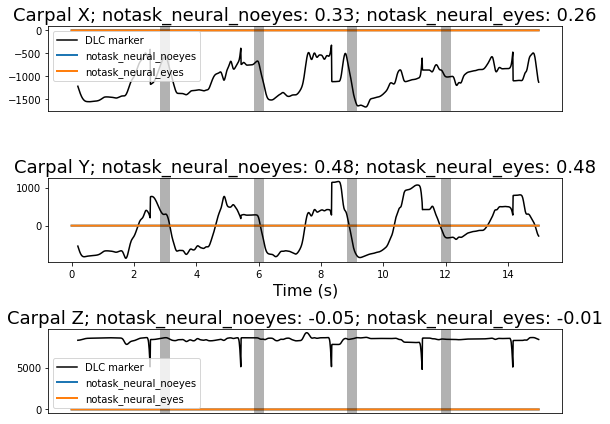

In [9]:
plt.figure(figsize=(8, 6))
tstart = 1200
bounds = np.arange(tstart, tstart + 1500)
x_vals = np.arange(len(bounds))/100

decoder_type = 'rnn'
cond1 = 'notask_neural_noeyes'
cond2 = 'notask_neural_eyes'

marker_names = ['Carpal X', 'Carpal Y', 'Carpal Z']
for col_idx in range(3):
    plt.subplot(3, 1, col_idx+1)
    plt.plot(x_vals[neural_offset:], y_test_data[bounds[:-neural_offset], col_idx], color='k', label='DLC marker')
    plt.plot(x_vals, decode_results[decoder_type][cond1]['test_pred'][bounds, col_idx], color='C0', linewidth=2, label=cond1)
    plt.plot(x_vals, decode_results[decoder_type][cond2]['test_pred'][bounds, col_idx], color='C1', linewidth=2, label=cond2)

    layout_corr = np.round(decode_results[decoder_type][cond1]['test_corr'][col_idx], 2)
    nolayout_corr = np.round(decode_results[decoder_type][cond2]['test_corr'][col_idx], 2)
    plt.title(f"{marker_names[col_idx]}; {cond1}: {layout_corr}; {cond2}: {nolayout_corr}", fontsize=18)
    
    if col_idx == 1:
        plt.xlabel('Time (s)', fontsize=16)
    else:
        plt.xticks([])
        plt.legend()
    
    plt.ylim(plt.ylim())
    plt.xlim(plt.xlim())
    
    plt.vlines(x=[3, 6, 9, 12],ymin=-10000, ymax=100000, color='k', linewidth=10, linestyle='-', alpha=0.3)
plt.tight_layout()
plt.savefig(f'movement_decoding_final.svg')

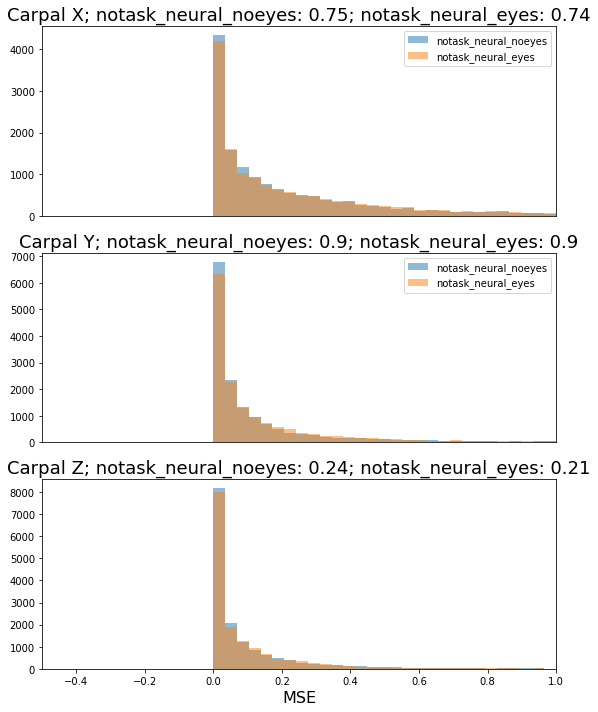

In [13]:
plt.figure(figsize=(8, 10))
tstart = 300

decoder_type = 'rnn'

marker_names = ['Carpal X', 'Carpal Y', 'Carpal Z']
bins = np.linspace(0,1,30)
for col_idx in range(3):
    plt.subplot(3, 1, col_idx+1)
    cond1_mse = np.square(decode_results[decoder_type][cond1]['test_pred'][:, col_idx] - y_test_data[:, col_idx])
    cond2_mse = np.square(decode_results[decoder_type][cond2]['test_pred'][:, col_idx] - y_test_data[:, col_idx])

    plt.hist(cond1_mse, color='C0', linewidth=2, label=cond1, bins=bins, alpha=0.5)
    plt.hist(cond2_mse, color='C1', linewidth=2, label=cond2, bins=bins, alpha=0.5)

    layout_corr = np.round(decode_results[decoder_type][cond1]['test_corr'][col_idx], 2)
    nolayout_corr = np.round(decode_results[decoder_type][cond2]['test_corr'][col_idx], 2)
    plt.title(f"{marker_names[col_idx]}; {cond1}: {layout_corr}; {cond2}: {nolayout_corr}", fontsize=18)
    
    if col_idx == 2:
        plt.xlabel('MSE', fontsize=16)
    else:
        plt.xticks([])
        plt.legend()
    
    #plt.ylim(plt.ylim(0, 4000))
    plt.xlim(plt.xlim(-0.5, 1))
    
plt.tight_layout()
#plt.savefig(f'movement_decoding_mse.svg')

(-0.05, 0.9)

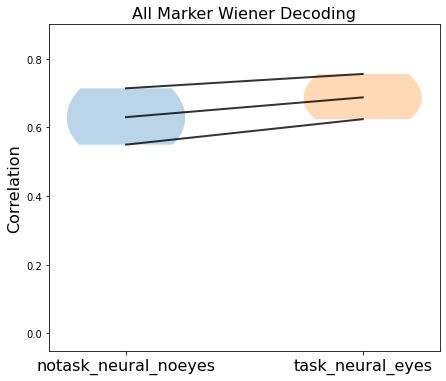

In [28]:
nolayout_test_corr = decode_results[decoder_type][cond1]['test_corr']
all_test_corr = decode_results[decoder_type][cond2]['test_corr']

plt.figure(figsize=(7,6))
plot_data = np.stack([nolayout_test_corr, all_test_corr])
_ = plt.plot(plot_data, color='k', linewidth=2, alpha=0.8)
plt.xticks([0, 1], labels=[cond1, cond2], fontsize=16)
plt.ylabel('Correlation', fontsize=16)
plt.violinplot(nolayout_test_corr, positions=[0], showmeans=False,showextrema=False)
plt.violinplot(all_test_corr, positions=[1], showmeans=False,showextrema=False)
plt.title('All Marker Wiener Decoding', fontsize=16)
plt.ylim([-0.05,0.9])

In [ ]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plot_data = np.stack([proxjoint_test_corr, all_test_corr, finger_test_corr])
_ = plt.plot(plot_data, color='k', linewidth=2, alpha=0.8)
plt.xticks([0, 1, 2], labels=['ProxJoint', 'Combined', 'Finger'], fontsize=16)
plt.ylabel('Correlation', fontsize=16)
plt.violinplot(proxjoint_test_corr, positions=[0], showmeans=False,showextrema=False)
plt.violinplot(all_test_corr, positions=[1], showmeans=False,showextrema=False)
plt.violinplot(finger_test_corr, positions=[2], showmeans=False,showextrema=False)
plt.title('ProxJoint/Finger vs. Combined', fontsize=16)
plt.ylim([-0.05,0.9])

plt.subplot(1,2,2)
plot_data = np.stack([finger_proxjoint_test_corr, all_test_corr, eyes_test_corr])
_ = plt.plot(plot_data, color='k', linewidth=2, alpha=0.8)
plt.xticks([0, 1, 2], labels=['Finger+ProxJoint', 'Combined', 'Eyes'], fontsize=16)
plt.ylabel('Correlation', fontsize=16)
plt.violinplot(finger_proxjoint_test_corr, positions=[0], showmeans=False,showextrema=False)
plt.violinplot(all_test_corr, positions=[1], showmeans=False,showextrema=False)
plt.violinplot(eyes_test_corr, positions=[2], showmeans=False,showextrema=False)
plt.title('Finger+ProxJoint/Eyes vs. Combined', fontsize=16)
plt.ylim([-0.05,0.9])

plt.savefig('single_unit_pred_final.svg')

In [ ]:
compare_data_list = [all_test_pred, eyes_test_pred, finger_test_pred, proxjoint_test_pred]
compare_data_names = ['Combined', 'Eyes', 'Fingers', 'Forelimb']

data_arrays, generators = make_generators(kinematic_df, neural_df, neural_offset=20)
    
# Unpack tuple into variables
training_set, validation_set, testing_set = data_arrays
training_generator, training_eval_generator, validation_generator, testing_generator = generators

X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

#Testing Data
plt.figure(figsize=(14,8))
bounds = np.arange(0,1500)
x_vals = np.arange(len(bounds))/100
unit_list = [4, 8, 16]

for row_idx, unit_idx in enumerate(unit_list):
    for plot_idx, (compare_data, name) in enumerate(zip(compare_data_list, compare_data_names)):
        plt.subplot(3,4, plot_idx+1 + (4*row_idx))
        plt.plot(x_vals, y_test_data[bounds,unit_idx], color='k')
        plt.ylim(plt.ylim())
        plt.plot(x_vals, compare_data[bounds,unit_idx], color=f'C{plot_idx + 1}')
        plt.title(f'{name}: Unit {unit_idx}')
        #plt.ylim([-3, 3.7])
        
        if plot_idx == 0:
            plt.ylabel('Firing Rate (a.u.)')
            
        if row_idx == 2:
            plt.xlabel('Time (s)')
        else:
            plt.xticks([])

    plt.tight_layout()